In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc

# Part 1: Face Detection

In [2]:
# Question 2
def MakeGaussianPyramid(image, scale, minsize):
  """Creates a pyramid, a scaled representation of the input image.

  Args:
    image (PIL.Image): an original PIL Image
    scale (float): a scale factor from one level to the next
    minsize (int): a minimum size of a larger dimension of the scaled image

  Returns:
    list (3D floating point numpy array): the original PIL image followed by
         all the PIL of images of reduced size
  """

  # Get input image information
  im_array = np.asfarray(image)

  width, height = image.size
  im_mode = image.mode

  sigma = 1/(2*scale)

  # Construct a pyramid
  pyramid = [im_array]

  while max(int(width*scale),int(height*scale)) >= minsize:
    # Smooth the image using gaussian filter
    if im_mode == "L": # Grayscale
      filtered_arr = ndimage.gaussian_filter(im_array, sigma)
    else: # Color img
      filtered_arr = np.stack([ndimage.gaussian_filter(im_array[:, :, c], sigma) for c in range(3)], axis=2)

    filtered_im = Image.fromarray(filtered_arr.astype('uint8'))

    # Scale it down
    width = int(width*scale)
    height = int(height*scale)
    scaled_img = filtered_im.resize((width,height), Image.BICUBIC)

    # Update im_array
    im_array = np.asfarray(scaled_img)
    pyramid.append(im_array)

  return pyramid

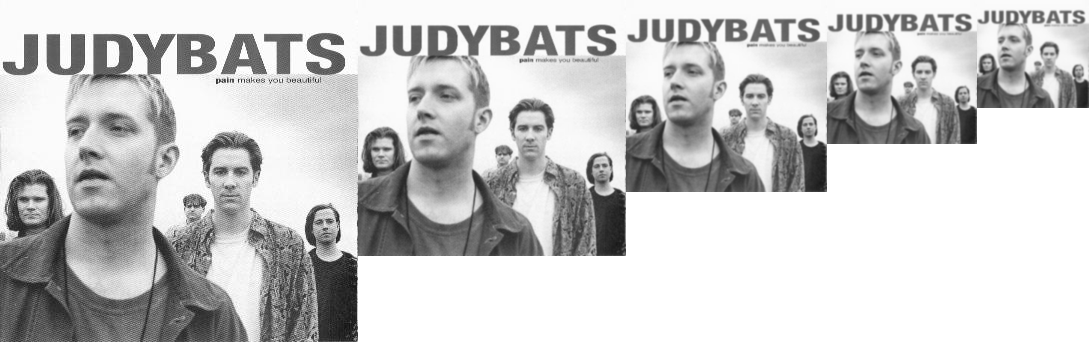

In [3]:
# Question 3
def ShowGaussianPyramid(pyramid):
  """Joins all the images in the pyramid into one horizontal image and display it.

  Args:
    pyramid (List of numpy array): 2D numpy array for grayscale img

  Returns:
    None
  """

  # Total width and height
  height = pyramid[0].shape[0]
  width = sum(img.shape[1] for img in pyramid)

  # Create a blank image
  if pyramid[0].ndim == 2:
    image = Image.new("L", (width, height), color=255)
  else:
    image = Image.new("RGB", (width, height), color="white")

  offset_x = 0
  offset_y = 0
  # Join images in the blank image
  for p in pyramid:
    im = Image.fromarray(p.astype('uint8'))
    image.paste(im,(offset_x,offset_y))
    offset_x += p.shape[1]

  display(image)


# Test
img = Image.open("judybats.jpg")
pyramid = MakeGaussianPyramid(img, 0.75, 100)
ShowGaussianPyramid(pyramid)

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


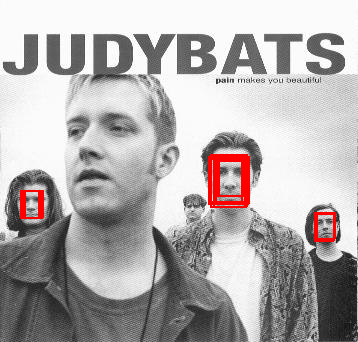

In [4]:
# Quesetion 4
def FindTemplate(pyramid, template, threshold):
  """Marks all locations in the pyramid at which the normalized cross correlation
     (NCC) of the template with the image is above the threshold.

  Args:
    pyramid (List of numpy array): a pyramid of images
    template (PIL.Image) : a template image
    threshold:

  Returns:
    PIL.Image

  """
  TEMPLATE_WIDTH = 15
  TEMPLATE_HEIGHT = int((template.height * TEMPLATE_WIDTH) / template.width)
  template = template.resize((TEMPLATE_WIDTH,TEMPLATE_HEIGHT), Image.BICUBIC)
  template_half_width = template.width // 2
  template_half_height = template.height // 2
  # print(template)

  original_img = Image.fromarray(pyramid[0].astype('uint8')).convert('RGB')
  i = 0
  for img_arr in pyramid:
    image = Image.fromarray(img_arr.astype('uint8'))
    ncc_arr = ncc.normxcorr2D(image, template)
    matches = np.where(ncc_arr > threshold)

    resize_scale = SCALE ** i
    for (y, x) in zip(*matches):
      # Get the four corners of the template and scale it back to the original image size
      x1 = int((x - template_half_width) / resize_scale)
      y1 = int((y - template_half_height) / resize_scale)
      x2 = int((x + template_half_width) / resize_scale)
      y2 = int((y + template_half_height) / resize_scale)

      # Draw the rectangle
      draw = ImageDraw.Draw(original_img)
      draw.line((x1,y1,x2,y1), fill="red", width=2)
      draw.line((x1,y1,x1,y2), fill="red", width=2)
      draw.line((x1,y2,x2,y2), fill="red", width=2)
      draw.line((x2,y1,x2,y2), fill="red", width=2)
      del draw

    i += 1

  return original_img

# Test
img = Image.open("judybats.jpg")
template = Image.open("template.jpg")
SCALE = 0.75
pyramid = MakeGaussianPyramid(img, SCALE, 100)
output = FindTemplate(pyramid, template, 0.65)
display(output)

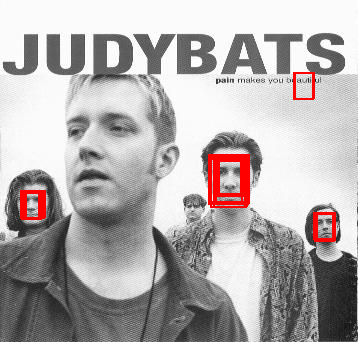

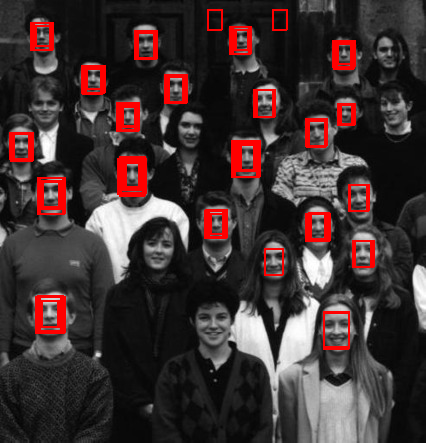

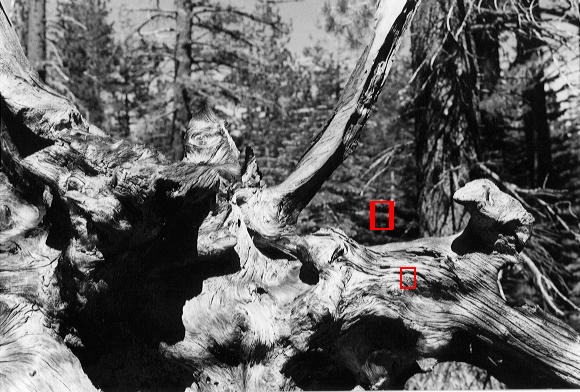

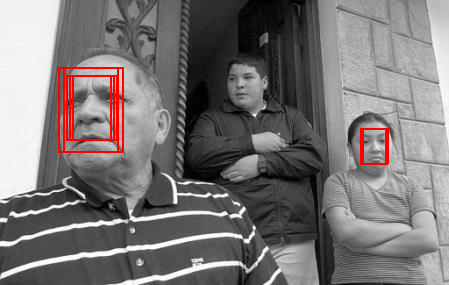

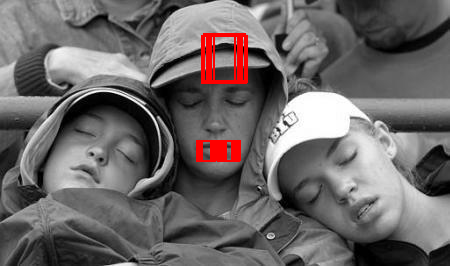

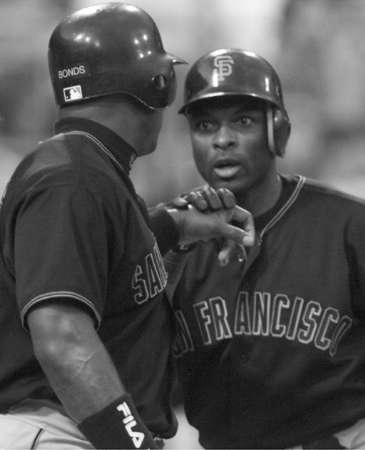

In [5]:
# Question 5
images = ["judybats.jpg", "students.jpg", "tree.jpg", "family.jpg","fans.jpg","sports.jpg"]
template = Image.open("template.jpg")
SCALE = 0.75
for img in images:
  im = Image.open(img)
  pyramid = MakeGaussianPyramid(im, SCALE, 100)
  output = FindTemplate(pyramid, template, 0.61)
  display(output)

Question 5

Threshold = 0.61 works the best.

(FP, FN)
1. judybats (1, 2)
2. students (2, 6)
3. tree (0, 2)
4. family (0, 1)
5. fans (2, 3)
6. sports (0, 1)

Question 6

Recall rate = TP / (TP + FN)

1. judybats = 3 / 5 = 0.6
2. students = 21 / 27 = 0.77778
3. tree = 0 / 2 = 0
4. family = 2 / 3 = 0.66667
5. fans = 0 / 3 = 0
6. sports = 0 / 1 = 0

The NCC method on some images has a very low recall rate because it is very sensitive to the variations in illumination, scale, and rotation of an image. For instance, in fans.jpg, it is failing to find a face becuase the characters in the image are wearing hats.

# Part 2: Image Blending

In [6]:
# Question 2
def MakeLaplacianPyramid(image, scale, minsize):
  """Creates a Laplacian pyramid for an image.

  Args:
    image (PIL.Image): an input image
    scale (float): a scale factor from one level to the next
    minsize (int): a minimum size of a larger dimension of the scaled image

  Returns:
    list (3D floating point numpy array): the original PIL image followed by
        all the PIL of images of reduced size
  """
  gaussian_pyramid = MakeGaussianPyramid(image, scale, minsize)
  laplacian_pyramid = []
  sigma = 1/(2*scale)

  for i in range(len(gaussian_pyramid) - 1):
    gaussian = gaussian_pyramid[i]
    blurred_arr = np.stack([ndimage.gaussian_filter(gaussian[:, :, c], sigma) for c in range(3)], axis=2)
    laplacian_arr = gaussian - blurred_arr
    laplacian_pyramid.append(laplacian_arr)

  # Append highest level
  laplacian_pyramid.append(gaussian_pyramid[-1])

  return laplacian_pyramid

Violet laplacian pyramid: 



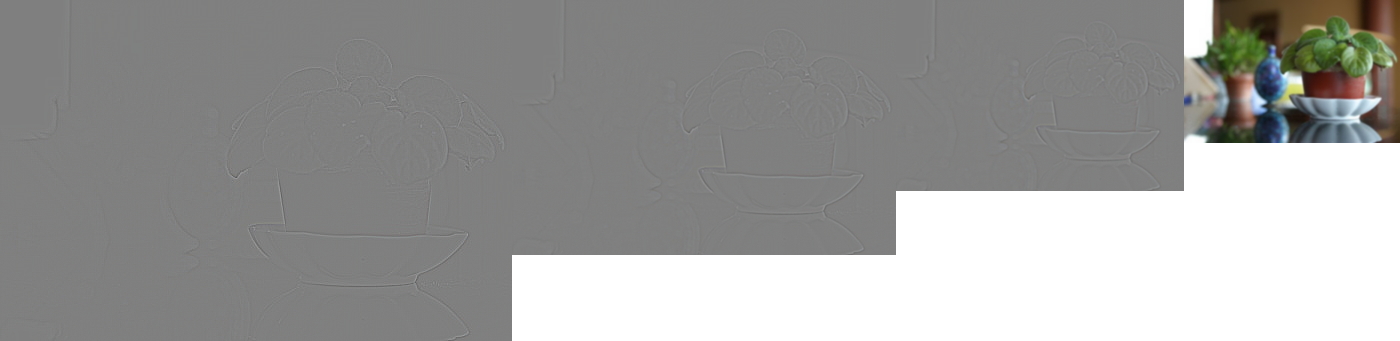

Orchid laplacian pyramid: 



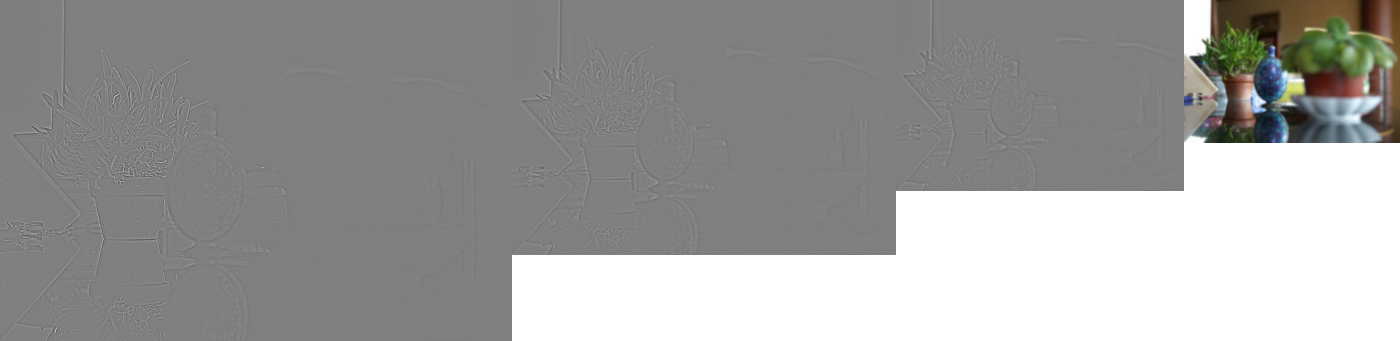

In [7]:
# Question 3
def ShowLaplacianPyramid(pyramid):
  """Joins all the images in the pyramid into one image and display it.

  Args:
    pyramid (list of 3d numpy array)

  Returns:
    None
  """
  # Total width and height
  height = pyramid[0].shape[0]
  width = sum(img.shape[1] for img in pyramid)

  # Create a blank image
  image = Image.new("RGB", (width, height), color="white")

  offset_x = 0
  offset_y = 0
  # Join images in the blank image
  for i in range(len(pyramid)):
    arr = pyramid[i]

    if(i != len(pyramid) - 1):
      # Extract RGB channels and clip each value
      r_img_array = arr[:,:,0]
      g_img_array = arr[:,:,1]
      b_img_array = arr[:,:,2]

      arr[:,:,0] = np.clip(r_img_array+ 128, 0, 255)
      arr[:,:,1] = np.clip(g_img_array + 128, 0, 255)
      arr[:,:,2] = np.clip(b_img_array + 128, 0, 255)

    # Covert the array back to an image
    img = Image.fromarray(arr.astype('uint8'))
    image.paste(img,(offset_x,offset_y))
    offset_x += arr.shape[1]

  display(image)


# Test
violet_img = Image.open("violet.jpg")
violet_lPyramid = MakeLaplacianPyramid(violet_img, 0.75, 200)

orchid_img = Image.open("orchid.jpg")
orchid_lPyramid = MakeLaplacianPyramid(orchid_img, 0.75, 200)

print("Violet laplacian pyramid: \n")
ShowLaplacianPyramid(violet_lPyramid)
print("Orchid laplacian pyramid: \n")
ShowLaplacianPyramid(orchid_lPyramid)

Reconstructed Violet gaussian pyramid: 



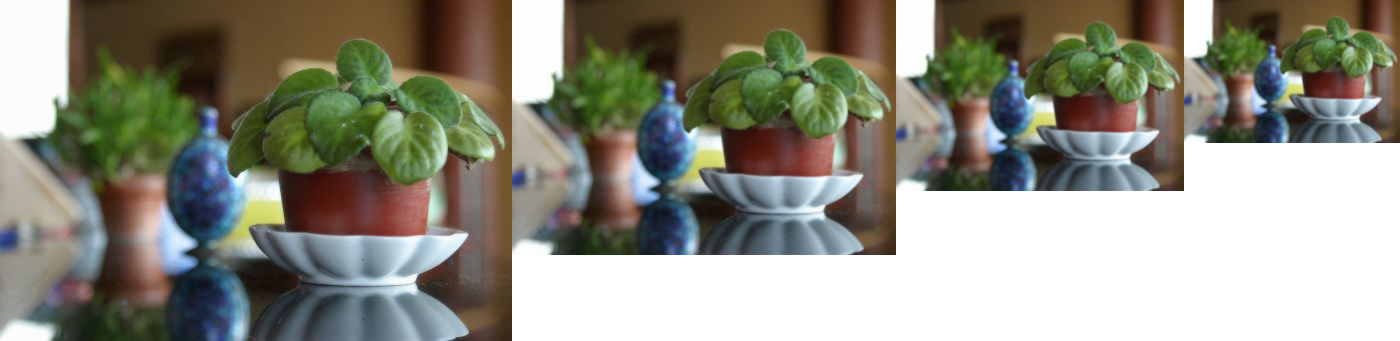

Reconstructed Orchid gaussian pyramid: 



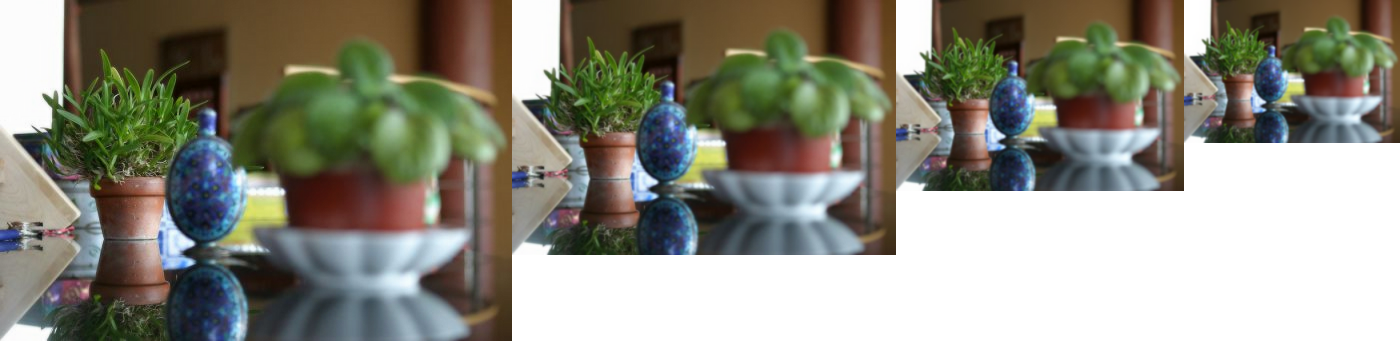

In [8]:
# Question 4
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  """Reconstructs Gaussian pyramid of that image from a Laplacian one."""
  gPyramid = []

  top_level_arr = lPyramid[-1]
  gPyramid.insert(0, top_level_arr)

  # Bottom-up reconstruction starting from second to the last img
  for i in range(len(lPyramid)-2, -1, -1):
    # Get the dimension of an image of the next level for upsampling
    width = lPyramid[i].shape[1]
    height =  lPyramid[i].shape[0]

    # Upsample it
    gaussian_img = Image.fromarray(gPyramid[0].astype('uint8'))
    upsample_img = gaussian_img.resize((width, height), Image.BICUBIC)
    upsample_arr = np.asfarray(upsample_img)

    # Add to the laplacian and clip the values
    gaussian = np.clip(upsample_arr + lPyramid[i], 0, 255)
    gPyramid.insert(0, gaussian)

  return gPyramid


# Test
violet_img = Image.open("violet.jpg")
violet_lPyramid = MakeLaplacianPyramid(violet_img, 0.75, 200)
violet_gPyramid = ReconstructGaussianFromLaplacianPyramid(violet_lPyramid)

orchid_img = Image.open("orchid.jpg")
orchid_lPyramid = MakeLaplacianPyramid(orchid_img, 0.75, 200)
orchid_gPyramid = ReconstructGaussianFromLaplacianPyramid(orchid_lPyramid)

print("Reconstructed Violet gaussian pyramid: \n")
ShowGaussianPyramid(violet_gPyramid)
print("Reconstructed Orchid gaussian pyramid: \n")
ShowGaussianPyramid(orchid_gPyramid)

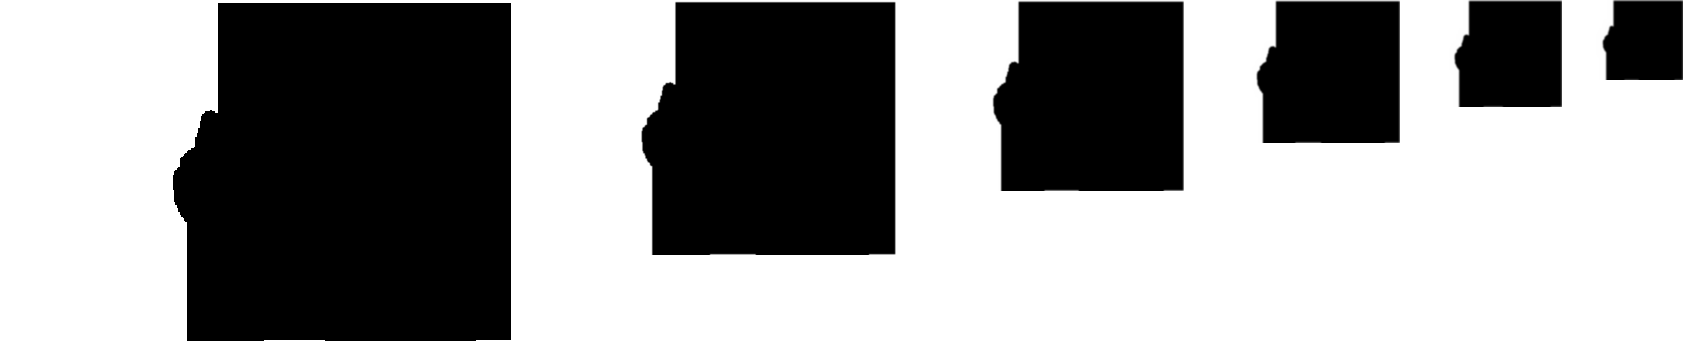

In [9]:
# Question 5
mask_img = Image.open("orchid_mask.bmp")
mask_gPyramid = MakeGaussianPyramid(mask_img, 0.75, 100)
ShowGaussianPyramid(mask_gPyramid)

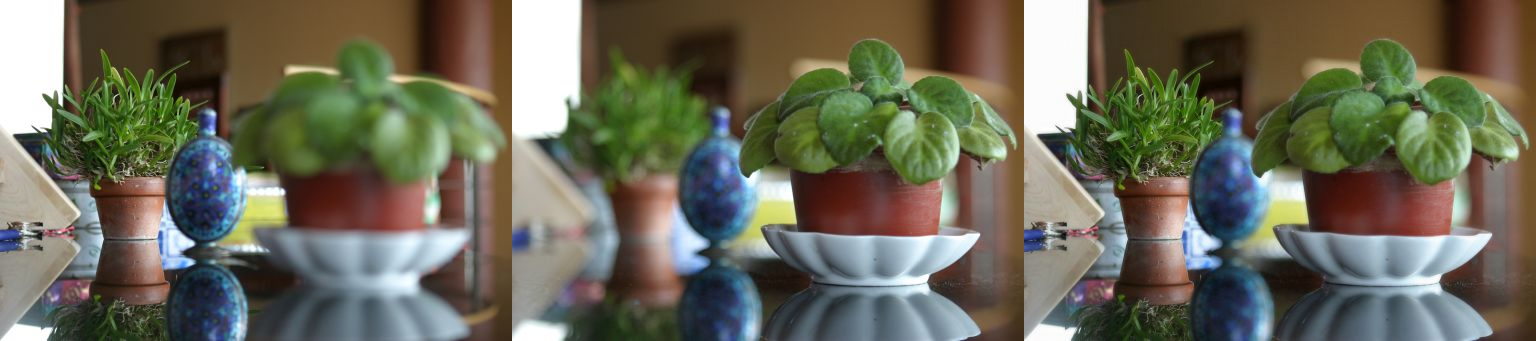

In [10]:
# Question 6
def ComposeLaplacianPyramids(img1, img2, mask, scale, minsize):
  """Composes the two laplacian pyramids level by level."""
  lapA = MakeLaplacianPyramid(img1, scale, minsize)
  lapB = MakeLaplacianPyramid(img2, scale, minsize)

  mask = mask.convert('RGB')
  gaussianM = MakeGaussianPyramid(mask, scale, minsize)

  compLaplacian = []
  for i in range(len(lapA)):
    comp = lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)
    compLaplacian.append(comp)

  return compLaplacian

# Test
violet_img = Image.open("violet.jpg")
orchid_img = Image.open("orchid.jpg")
mask_img = Image.open("orchid_mask.bmp")

compLap = ComposeLaplacianPyramids(orchid_img, violet_img, mask_img, 0.75, 200)
blended = ReconstructGaussianFromLaplacianPyramid(compLap)

images = np.hstack([np.uint8(i) for i in (orchid_img, violet_img, blended[0])])
display(Image.fromarray(images))

Tomato and apple blend: 



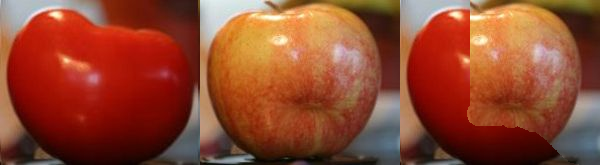

Blue cup and green cup blend: 



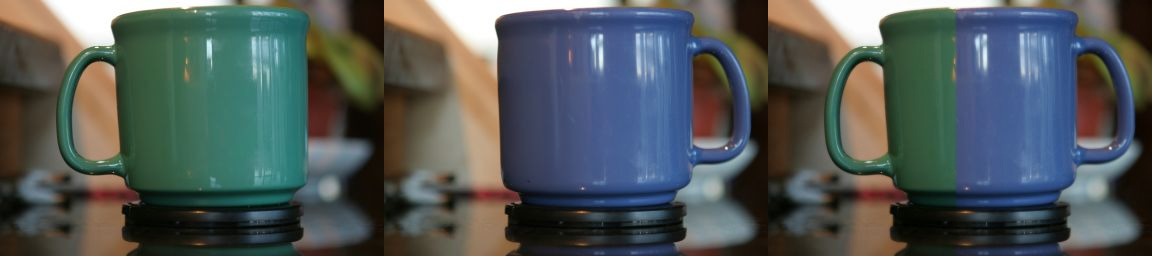

In [13]:
# Question 7
print("Tomato and apple blend: \n")
tomato_img = Image.open("tomato.jpg")
apple_img = Image.open("apple.jpg")
tomato_mask_img = Image.open("tomato_mask.bmp")

compLap1 = ComposeLaplacianPyramids(tomato_img, apple_img, tomato_mask_img, 0.75, 200)
blended1 = ReconstructGaussianFromLaplacianPyramid(compLap1)

images1 = np.hstack([np.uint8(i) for i in (tomato_img, apple_img, blended1[0])])
display(Image.fromarray(images1))

print("Blue cup and green cup blend: \n")
blue_img = Image.open("blue_cup.jpg")
green_img = Image.open("green_cup.jpg")
cup_mask_img = Image.open("cup_mask.bmp")

compLap2 = ComposeLaplacianPyramids(green_img, blue_img, cup_mask_img, 0.75, 200)
blended2 = ReconstructGaussianFromLaplacianPyramid(compLap2)

images2 = np.hstack([np.uint8(i) for i in (green_img, blue_img, blended2[0])])
display(Image.fromarray(images2))